In [1]:
# silencing some logs/warning
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
%env WANDB_SILENT=True

# importing packages
import os
import sys
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import wandb

# importing our functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from process_data import process_data
from evaluate import evaluate_pred, print_dummy_evaluations
from visualization import plot_confusion_matrix, plot_correlations
from utils.constants import SEED

env: WANDB_SILENT=True


In [2]:
wandb.login()

True

# Get data

In [3]:
split_prec = {
    'train': 0.5,
    'valid': 0.3,
    'test': 0.2
}

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = process_data(split_prec, dropped_columns=['snow', 'temp_fahrenheit'])
#X_train, X_test, Y_train, Y_test = process_data(split_prec, dropped_columns=['snow', 'temp_fahrenheit', 'good_weather', 'weekday'])
columns = X_train.columns.to_list()

Dropped columns: ['snow']
New columns: ['good_weather' 'is_day']
Split: "train" 	[Size: 800] 	[Prec: 0.5]
	X: (800, 16)
	Y: (800,)
Split: "valid" 	[Size: 480] 	[Prec: 0.3]
	X: (480, 16)
	Y: (480,)
Split: "test" 	[Size: 320] 	[Prec: 0.2]
	X: (320, 16)
	Y: (320,)


In [4]:
# print label ratios
def get_label_ratio(Y: pd.DataFrame) -> dict:
    counts = Y.value_counts()
    return {'0': counts[0], '1': counts[1], 'minority_ratio': round(counts[1]/counts.sum(), 4)}

label_ratio = get_label_ratio(Y_train)
print(f'Train ratio [0:1] -> [{label_ratio["0"]:>4}:{label_ratio["1"]:<4}] (minority ratio: {label_ratio["minority_ratio"]:0.2%})')
label_ratio = get_label_ratio(Y_valid)
print(f'Valid ratio [0:1] -> [{label_ratio["0"]:>4}:{label_ratio["1"]:<4}] (minority ratio: {label_ratio["minority_ratio"]:0.2%})')
label_ratio = get_label_ratio(Y_test)
print(f'Test ratio  [0:1] -> [{label_ratio["0"]:>4}:{label_ratio["1"]:<4}] (minority ratio: {label_ratio["minority_ratio"]:0.2%})')

Train ratio [0:1] -> [ 654:146 ] (minority ratio: 18.25%)
Valid ratio [0:1] -> [ 386:94  ] (minority ratio: 19.58%)
Test ratio  [0:1] -> [ 272:48  ] (minority ratio: 15.00%)


In [5]:
### Oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
#sampler = RandomOverSampler(random_state=SEED)
sampler = SMOTE(sampling_strategy=1.0, random_state=SEED)
X_train, Y_train = sampler.fit_resample(X_train, Y_train)
label_ratio = get_label_ratio(Y_train)
print(f'Train ratio AFTER resample [0:1] -> [{label_ratio["0"]:>4}:{label_ratio["1"]:<4}] (minority ratio: {label_ratio["minority_ratio"]:0.2%})')

Train ratio AFTER resample [0:1] -> [ 654:654 ] (minority ratio: 50.00%)


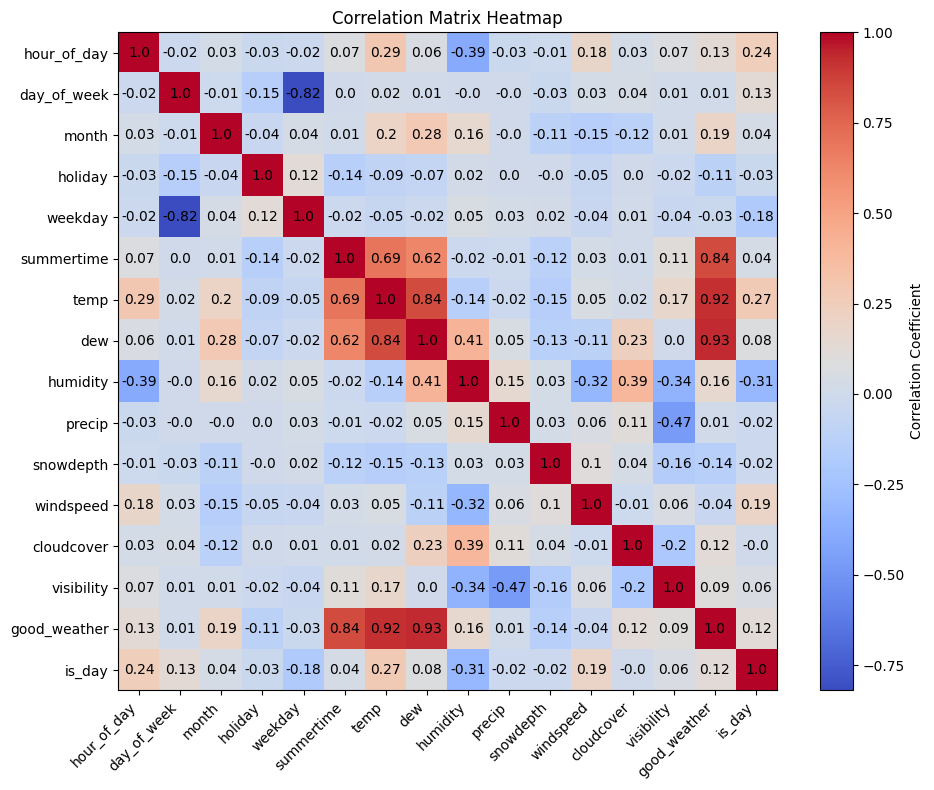

In [6]:
plot_correlations(X_train)

# Hyperparameter Optimization
1. Set up configuration (possible values)
2. Run optimization
3. Get best parameters

In [7]:
## 1. Set up configuration

PROJECT_NAME = 'SML'
PROJECT_ENTITY = 'daniel-veress'

NUMBER_OF_RUNS = 300

sweep_configuration = {
    'method': 'bayes',
    'metric': {'goal': 'maximize', 'name': 'mix'},
    'parameters': {
        'criterion': {'values': ['gini', 'entropy', 'log_loss']},
        'max_depth': {'max': 150, 'min': 100},
        'min_samples_split': {'max': 32, 'min': 2},
        'min_samples_leaf': {'max': 32, 'min': 1},
        'min_weight_fraction_leaf': {'max': 0.1, 'min': 0.0},
        'max_features': {'values': ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
        'min_impurity_decrease': {'max': 0.1, 'min': 0.0},
        'class_weight': {'values': ['balanced', 'balanced_subsample', None]},
        'ccp_alpha': {'max': 0.1, 'min': 0.0}
    }
}

sweep_id = wandb.sweep(
    project=PROJECT_NAME,
    sweep=sweep_configuration
)

Create sweep with ID: tfqeubc7
Sweep URL: https://wandb.ai/daniel-veress/SML/sweeps/tfqeubc7


In [8]:
## 2. Run optimization
def objective(config):
    # creating the model
    model = RandomForestClassifier(
        n_estimators=125,
        criterion=config.criterion,
        max_depth=config.max_depth,
        min_samples_split=config.min_samples_split,
        min_samples_leaf=config.min_samples_leaf,
        min_weight_fraction_leaf=config.min_weight_fraction_leaf,
        max_features=config.max_features,
        min_impurity_decrease=config.min_impurity_decrease,
        class_weight=config.class_weight,
        ccp_alpha=config.ccp_alpha,
        random_state=SEED
    )

    # training
    model.fit(X_train, Y_train)
    
    # evaluating
    y_pred = model.predict(X_valid)
    y_true = Y_valid
    metrics = evaluate_pred(y_pred, y_true)
    return metrics

def main():
    run = wandb.init(
      project=PROJECT_NAME,
      config={
          'columns': columns
      }
    )
    metrics = objective(wandb.config)
    wandb.log(metrics)


# start sweeping/optimization
wandb.agent(sweep_id, function=main, count=NUMBER_OF_RUNS)
wandb.finish()

In [9]:
## 3. Get best parameters/run
api = wandb.Api()
sweep = api.sweep(f'{PROJECT_ENTITY}/{PROJECT_NAME}/sweeps/{sweep_id}')
best_run = sweep.best_run(order='accuracy')

print('Best hyperparameters:')
best_parameters = best_run.config
non_model_parameters = ['scaler', 'splits', 'columns']
hyperparameters = {}
for param, value in best_parameters.items():
    print(f'{param}: {value}')
    # correct parameters, so only model hyperparameters are included
    if param not in non_model_parameters:
        hyperparameters[param] = value

print('\nMetrics:')
best_metrics = best_run.summary
for param, value in best_metrics.items():
    if '_' != param[0]:
        print(f'{param:<10}: {value}')

Best hyperparameters:
columns: ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'good_weather', 'is_day']
ccp_alpha: 0.00137452208774832
criterion: entropy
max_depth: 105
class_weight: None
max_features: 0.8
min_samples_leaf: 6
min_samples_split: 3
min_impurity_decrease: 0.000954900235090006
min_weight_fraction_leaf: 0.013099233214064244

Metrics:
accuracy  : 0.8791666666666667
mix       : 4.8272706474490965
precision : 0.6451612903225806
recall    : 0.851063829787234


# Training

In [15]:
CONCAT_TRAIN_VALID = True

import pandas as pd
if CONCAT_TRAIN_VALID:
    X_t = pd.concat([X_train, X_valid])
    Y_t = pd.concat([Y_train, Y_valid])
    sampler = SMOTE(sampling_strategy=1.0, random_state=SEED)
    X_t, Y_t = sampler.fit_resample(X_t, Y_t)
else:
    X_t = X_train
    Y_t = Y_train
X_t.shape

(2080, 16)

In [16]:
#hyperparameters = {
#    'ccp_alpha': 0.005483643975784481,
#    'criterion': 'log_loss',
#    'max_depth': 113,
#    'max_features': 0.4,
#    'min_impurity_decrease': 0.004369421068858448,
#    'min_samples_leaf': 2,
#    'min_samples_split': 11,
#    'min_weight_fraction_leaf': 0.003034426238130361,
#    'bootstrap':True,
#    'class_weight': None
#}

model = RandomForestClassifier(
    **hyperparameters, 
    random_state=SEED
)
model.fit(X_t, Y_t)

RandomForestClassifier(ccp_alpha=0.00137452208774832, criterion='entropy',
                       max_depth=105, max_features=0.8,
                       min_impurity_decrease=0.000954900235090006,
                       min_samples_leaf=6, min_samples_split=3,
                       min_weight_fraction_leaf=0.013099233214064244,
                       random_state=1)

# Evaluating

In [17]:
def evaluate_on_dataset(X, Y, model):
    y_pred = model.predict(X)
    y_true = Y

    return evaluate_pred(y_pred, y_true)

In [18]:
print('-- Random Forest model --\n')
print('* Train *')
metrics = evaluate_on_dataset(X_train, Y_train, model)
for metric, value in metrics.items():
    print(f'  {metric.capitalize()}: \t{value}')
print('* Valid *')
metrics = evaluate_on_dataset(X_valid, Y_valid, model)
for metric, value in metrics.items():
    print(f'  {metric.capitalize()}: \t{value}')
print('* Test *')
metrics = evaluate_on_dataset(X_test, Y_test, model)
for metric, value in metrics.items():
    print(f'  {metric.capitalize()}: \t{value}')

print('\n-- Dummy models -- ')
print_dummy_evaluations(X_train, Y_train, X_test, Y_test)

-- Random Forest model --

* Train *
  Accuracy: 	0.9472477064220184
  Recall: 	0.9801223241590215
  Precision: 	0.9196556671449068
  Mix: 	8.538254486514626
* Valid *
  Accuracy: 	0.9125
  Recall: 	0.8936170212765957
  Precision: 	0.7241379310344828
  Mix: 	5.904805575935436
* Test *
  Accuracy: 	0.865625
  Recall: 	0.7916666666666666
  Precision: 	0.5352112676056338
  Mix: 	3.667730340375586

-- Dummy models -- 

Most_frequent
  Accuracy: 	0.85
  Recall: 	0.0
  Precision: 	0.0
  Mix: 	0.0

Stratified
  Accuracy: 	0.4875
  Recall: 	0.3541666666666667
  Precision: 	0.11333333333333333
  Mix: 	0.19567708333333333

Uniform
  Accuracy: 	0.503125
  Recall: 	0.5625
  Precision: 	0.16363636363636364
  Mix: 	0.4631036931818182


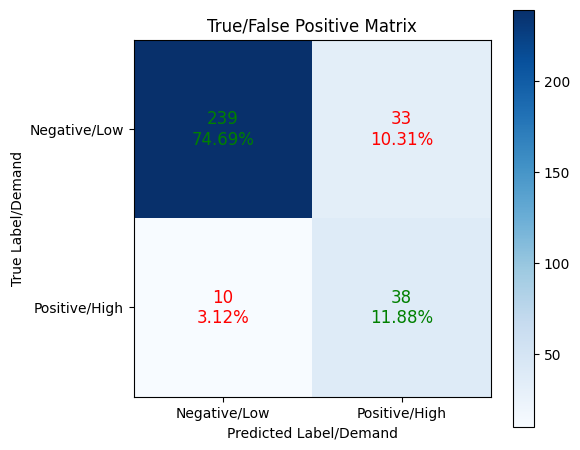

True Positive (TP): 38
True Negative (TN): 239
False Positive (FP): 33
False Negative (FN): 10


In [14]:
# Confusion matrix

y_pred = model.predict(X_test)
y_true = Y_test

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
confusion_matrix_data = np.array([[tn, fp], [fn, tp]])
plot_confusion_matrix(confusion_matrix_data)

print(f'True Positive (TP): {tp}')
print(f'True Negative (TN): {tn}')
print(f'False Positive (FP): {fp}')
print(f'False Negative (FN): {fn}')